In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import pathlib
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications import Xception, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling, RandomZoom
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam

In [3]:
# Set the path to the split dataset directory
split_dataset_dir = '/content/drive/MyDrive/Dataset_divided'


In [4]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation Configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

# Assuming your data is divided into 'train' and 'valid' directories within 'split_dataset_dir'
train_generator = train_datagen.flow_from_directory(
    os.path.join(split_dataset_dir, 'train'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(split_dataset_dir, 'valid'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

train_dataset = train_generator
validation_dataset = validation_generator


Found 7350 images belonging to 4 classes.
Found 1578 images belonging to 4 classes.


In [6]:
# Preprocess the data
AUTOTUNE = tf.data.AUTOTUNE



In [7]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten


# Define input shape for both models
input_shape = (128, 128, 3)

# Load Xception model
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Load DenseNet121 model
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Define input shape for both models
input_shape = (128, 128, 3)

# Define inputs
inputs = Input(shape=input_shape)

# Get the outputs of the base models
Xception_output = base_model_xception(inputs)
densenet121_output = base_model_densenet(inputs)

# Concatenate the outputs
concatenated = Concatenate()([Xception_output, densenet121_output])

# Freeze the first three layers of base models
for layer in base_model_xception.layers[:3]:
    layer.trainable = False

for layer in base_model_densenet.layers[:3]:
    layer.trainable = False

x = Conv2D(64, (3, 3), activation='relu', padding='same')(concatenated)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)

x = Flatten()(x)

output = Dense(4, activation='softmax')(x)

# Create the ensemble model
ensemble_model = Model(inputs=inputs, outputs=output)

# Compile the model
ensemble_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)



# Define the learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.8
)

# Specify the path and filename for saving the model
model_save_path = '/content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_DenseNet121.h5'

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True),
    ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1),
    TensorBoard(log_dir='./logs', histogram_freq=1)
]


29084464/29084464 [==============================] - 0s 0us/step


In [8]:

ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 xception (Functional)       (None, 4, 4, 2048)           2086148   ['input_3[0][0]']             
                                                          0                                       
                                                                                                  
 densenet121 (Functional)    (None, 4, 4, 1024)           7037504   ['input_3[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 4, 4, 3072)           0         ['xception[0][0]',        

In [9]:
# Train the model
history = ensemble_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
230/230 [==============================] - ETA: 0s - loss: 1.7412 - accuracy: 0.4868
Epoch 1: val_loss improved from inf to 1.74346, saving model to /content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_DenseNet121.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


230/230 [==============================] - 2229s 9s/step - loss: 1.7412 - accuracy: 0.4868 - val_loss: 1.7435 - val_accuracy: 0.4119
Epoch 2/50
230/230 [==============================] - ETA: 0s - loss: 0.8428 - accuracy: 0.6460
Epoch 2: val_loss improved from 1.74346 to 1.04672, saving model to /content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_DenseNet121.h5
230/230 [==============================] - 111s 481ms/step - loss: 0.8428 - accuracy: 0.6460 - val_loss: 1.0467 - val_accuracy: 0.5830
Epoch 3/50
230/230 [==============================] - ETA: 0s - loss: 0.6973 - accuracy: 0.6893
Epoch 3: val_loss improved from 1.04672 to 0.63505, saving model to /content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_DenseNet121.h5
230/230 [==============================] - 111s 483ms/step - loss: 0.6973 - accuracy: 0.6893 - val_loss: 0.6350 - val_accuracy: 0.7376
Epoch 4/50
230/230 [==============================] - ETA: 0s - loss: 0.6083 - accuracy: 0.7245
Epoch 4: val_loss

In [10]:

# Save the entire model to a HDF5 file
ensemble_model.save('/content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_DenseNet121.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# Load the model from the HDF5 file
loaded_ensemble_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_DenseNet121.h5')


In [12]:
# Save the entire model to Google Drive
loaded_ensemble_model.save('/content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_DenseNet121.h5')

In [13]:
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_DenseNet121.h5')

# Compile the loaded model
loaded_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=['accuracy']
)

# Evaluate the model on the validation data generator
validation_loss, validation_accuracy = loaded_model.evaluate(validation_generator)
training_loss, training_accuracy = loaded_model.evaluate(train_generator) # Add this line

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)
print("Training Loss:", training_loss) # Add this line
print("Training Accuracy:", training_accuracy) # Add this line

230/230 [==============================] - 65s 281ms/step - loss: 0.0427 - accuracy: 0.9850
Validation Loss: 0.09980154782533646
Validation Accuracy: 0.9664131999015808
Training Loss: 0.042691197246313095
Training Accuracy: 0.9850339889526367


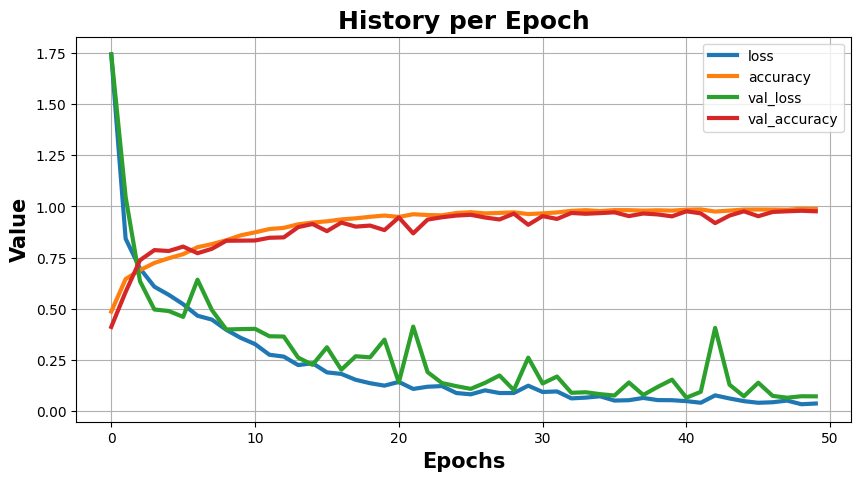

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training history
df = pd.DataFrame(history.history)

# Create the plot
ax = df.plot(figsize=(10, 5), lw=3)
ax.grid(True)
ax.set_title('History per Epoch', fontsize=18, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax.set_ylabel('Value', fontsize=15, fontweight='bold')

# Show the plot
plt.show()

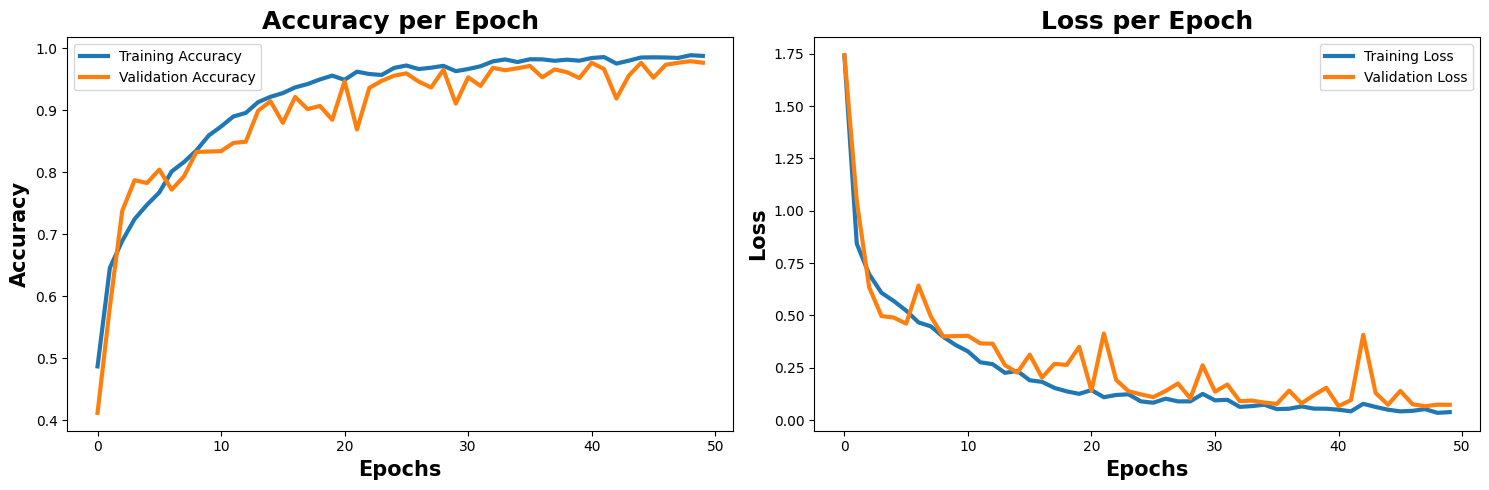

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training history
df = pd.DataFrame(history.history)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(df['accuracy'], label='Training Accuracy', lw=3)
ax1.plot(df['val_accuracy'], label='Validation Accuracy', lw=3)
ax1.set_title('Accuracy per Epoch', fontsize=18, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=15, fontweight='bold')
ax1.legend()

# Plot loss
ax2.plot(df['loss'], label='Training Loss', lw=3)
ax2.plot(df['val_loss'], label='Validation Loss', lw=3)
ax2.set_title('Loss per Epoch', fontsize=18, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=15, fontweight='bold')
ax2.legend()

# Adjust layout for better spacing
fig.tight_layout()

# Show the plot
plt.show()



In [ ]:
# Save the entire model to Google Drive
loaded_ensemble_model.save('/content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_DenseNet121.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


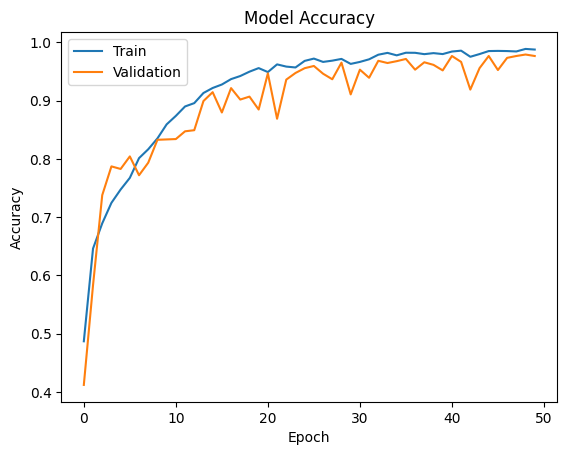

In [16]:

# Visualize Training History
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Save the entire model to a HDF5 file
loaded_ensemble_model.save('/content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_DenseNet121.h5')


Found 1574 images belonging to 4 classes.
Precision: 0.9463
Recall: 0.9479
F1 Score: 0.9456
Accuracy: 0.9441



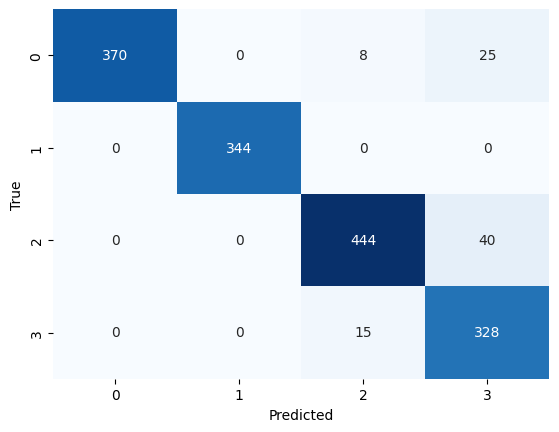

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Get the names of the four classes
class_names = ["Non_Demented", "Very_Mild_Demented", "Moderate_Demented", "Mild_Demented"]

# Set the path to your test dataset directory
test_dataset_dir = os.path.join(split_dataset_dir, 'test')

# Create a data generator for testing
data_generator = ImageDataGenerator(rescale=1.0 / 255.0)

# Load the test data
test_generator = data_generator.flow_from_directory(
    test_dataset_dir,
    target_size=(128, 128),
    batch_size=1,  # Set batch_size to 1 for individual predictions
    class_mode=None,  # Do not specify class_mode for raw predictions
    shuffle=False
)

# Perform individual predictions and calculate metrics for each model
individual_predictions = []

for j in range(len(test_generator.filenames)):
    batch_images = next(test_generator)
    prediction = ensemble_model.predict(batch_images, verbose=0)
    individual_predictions.append(np.argmax(prediction))

# Calculate and store metrics for the model
precision = precision_score(test_generator.classes, individual_predictions, average='macro')
recall = recall_score(test_generator.classes, individual_predictions, average='macro')
f1 = f1_score(test_generator.classes, individual_predictions, average='macro')
accuracy = accuracy_score(test_generator.classes, individual_predictions)

ensemble_model_metrics = {
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Accuracy": accuracy
}

# Print metrics
print(f"Precision: {ensemble_model_metrics['Precision']:.4f}")
print(f"Recall: {ensemble_model_metrics['Recall']:.4f}")
print(f"F1 Score: {ensemble_model_metrics['F1 Score']:.4f}")
print(f"Accuracy: {ensemble_model_metrics['Accuracy']:.4f}")
print()

# Display confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, individual_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [19]:
# Save the updated model with the same name
loaded_ensemble_model.save('/content/drive/MyDrive/saved_model/Ensemble_Model_Xception_and_DenseNet121.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
